### Notebook for analzying trading data 2025 R5

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tabulate import tabulate
from scipy.stats import percentileofscore

def compute_price_percentile_rank(price_csv, trades_csv, trader_name="Caesar", side="buy", window=500, products=None):
    # Load CSVs
    prices = pd.read_csv(price_csv, delimiter=';')
    trades = pd.read_csv(trades_csv, delimiter=';')

    # Compute midprices
    prices["mid_price"] = (prices["ask_price_1"] + prices["bid_price_1"]) / 2

    # Filter trades for trader and side
    if side == "buy":
        trader_trades = trades[trades["buyer"] == trader_name]
    else:
        trader_trades = trades[trades["seller"] == trader_name]

    # Filter products if provided
    if products:
        trader_trades = trader_trades[trader_trades["symbol"].isin(products)]

    results = []

    for _, trade in trader_trades.iterrows():
        timestamp = trade["timestamp"]
        symbol = trade["symbol"]
        trade_price = trade["price"]

        # Slice surrounding midprices from prices
        price_slice = prices[
            (prices["product"] == symbol) &
            (prices["timestamp"] >= timestamp - window) &
            (prices["timestamp"] <= timestamp + window)
        ]

        if len(price_slice) < 5:
            continue  # skip if insufficient price data

        percent_rank = percentileofscore(price_slice["mid_price"], trade_price)

        results.append({
            "timestamp": timestamp,
            "symbol": symbol,
            "price": trade_price,
            "percentile": round(percent_rank, 2)
        })

    return pd.DataFrame(results)

def plot_trader_activity(price_csv, trades_csv, trader_name, symbol, side="buys"):
    # Load CSVs
    prices = pd.read_csv(price_csv, delimiter=";")
    trades = pd.read_csv(trades_csv, delimiter=";")

    # Ensure timestamp is int
    prices["timestamp"] = prices["timestamp"].astype(int)
    trades["timestamp"] = trades["timestamp"].astype(int)

    # Compute mid-price for selected symbol
    symbol_prices = prices[prices["product"] == symbol].copy()
    symbol_prices["mid_price"] = (symbol_prices["ask_price_1"] + symbol_prices["bid_price_1"]) / 2

    # Filter trades for trader and symbol
    if side == "buys":
        filtered_trades = trades[(trades["buyer"] == trader_name) & (trades["symbol"] == symbol)]
        color = "green"
        label = f"{trader_name} buys"
    elif side == "sells":
        filtered_trades = trades[(trades["seller"] == trader_name) & (trades["symbol"] == symbol)]
        color = "red"
        label = f"{trader_name} sells"
    else:
        raise ValueError("side must be 'buys' or 'sells'")

    # Determine time splits
    min_time = symbol_prices["timestamp"].min()
    max_time = symbol_prices["timestamp"].max()
    segment_length = (max_time - min_time) // 3
    boundaries = [min_time + i * segment_length for i in range(4)]

    # Create plot with 3 subplots (not sharing x-axis)
    fig, axs = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(f"{symbol} Mid-Price with {label} — Split by Time", fontsize=16)

    for i in range(3):
        start = boundaries[i]
        end = boundaries[i + 1]
        price_slice = symbol_prices[(symbol_prices["timestamp"] >= start) & (symbol_prices["timestamp"] < end)]
        trade_slice = filtered_trades[(filtered_trades["timestamp"] >= start) & (filtered_trades["timestamp"] < end)]

        axs[i].plot(price_slice["timestamp"], price_slice["mid_price"], color="black", label="Mid-price")
        if not trade_slice.empty:
            axs[i].scatter(trade_slice["timestamp"], trade_slice["price"],
                           color=color, marker="x", s=60, label=label)

        axs[i].set_xlim(start, end)
        axs[i].set_title(f"Time {start}–{end}")
        axs[i].set_ylabel("Price")
        axs[i].grid(True)
        axs[i].legend()

    axs[-1].set_xlabel("Timestamp")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def label_trade_quality(df):
    def classify(pct):
        if pct <= 33:
            return "Low"
        elif pct <= 66:
            return "Mid"
        else:
            return "High"

    df["category"] = df["percentile"].apply(classify)
    return df

In [7]:
df1 = pd.read_csv('data/2025/round5/trades_round_5_day_2.csv', delimiter=';')
df2 = pd.read_csv('data/2025/round5/trades_round_5_day_3.csv', delimiter=';')
df3 = pd.read_csv('data/2025/round5/trades_round_5_day_4.csv', delimiter=';')
df = pd.concat([df1, df2, df3], ignore_index=True)


**Basic exploration**

In [13]:
summary = {
    "unique_symbols": df["symbol"].nunique(),
    "unique_traders": len(set(df["buyer"]).union(set(df["seller"]))),
    "num_trades": len(df),
    "symbols": df["symbol"].value_counts(),
    "top_buyers": df["buyer"].value_counts().head(5),
    "top_sellers": df["seller"].value_counts().head(5),
}
print(summary["unique_traders"])

11


In [11]:
print(summary["top_buyers"])

buyer
Camilla     13053
Caesar      12598
Paris       10512
Charlie     10123
Penelope     3666
Name: count, dtype: int64


In [12]:
print(summary["top_sellers"])

seller
Caesar     16931
Paris      12135
Charlie     7183
Camilla     5885
Pablo       5672
Name: count, dtype: int64


**For each of the eleven traders, check what they trade most**

In [18]:
# Get list of all unique traders
traders = set(df["buyer"]).union(set(df["seller"]))

# Build summary table
summary = []

for trader in sorted(traders):
    bought = (
        df[df["buyer"] == trader]["symbol"]
        .value_counts()
        .head(3)
        .to_dict()
    )
    sold = (
        df[df["seller"] == trader]["symbol"]
        .value_counts()
        .head(3)
        .to_dict()
    )

    summary.append({
        "Trader": trader,
        "Top 3 Bought": ", ".join(f"{sym} ({cnt})" for sym, cnt in bought.items()),
        "Top 3 Sold": ", ".join(f"{sym} ({cnt})" for sym, cnt in sold.items()),
    })

# Display summary as a table
print(tabulate(summary, headers="keys", tablefmt="grid"))

+----------+----------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------+
| Trader   | Top 3 Bought                                                                                             | Top 3 Sold                                                                                               |
+==========+==========================================================================================================+==========================================================================================================+
| Caesar   | JAMS (2271), CROISSANTS (1845), DJEMBES (1693)                                                           | VOLCANIC_ROCK_VOUCHER_9750 (2172), VOLCANIC_ROCK_VOUCHER_10000 (2162), VOLCANIC_ROCK_VOUCHER_9500 (2115) |
+----------+--------------------------------------------------------------------------------

Looking at the above table, I think it is best to focus on the most active traders:
- Caesar (most bought: jams, croissants, djembes -- most sold V_9750, V_10000, V_9500)
- Camilla (most bought: V_9750, V_9500, V_10000 -- most sold: kelp, squid, resin)
- Charlie (most bought: squid, kelp, resin -- most sold: kelp, squid, resin)

Now we will look into their trades, to see if they bought/sold high/low.   
**Start with Caesar and his buys.**

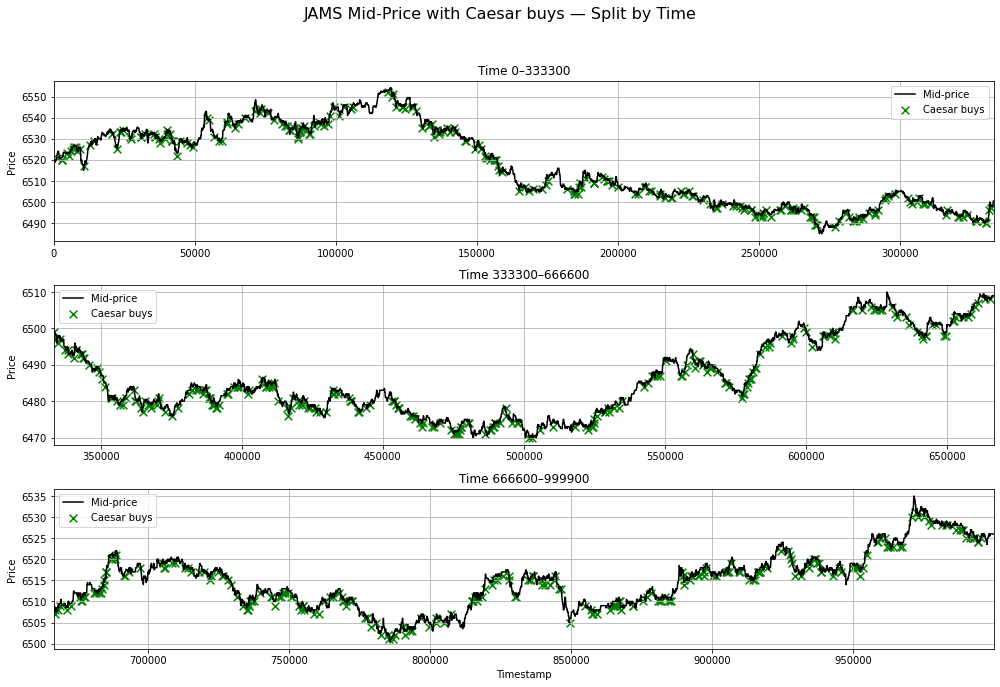

In [32]:
plot_trader_activity(
    "data/2025/round5/prices_round_5_day_2.csv",
    "data/2025/round5/trades_round_5_day_2.csv",
    trader_name="Caesar",
    symbol="JAMS",
    side="buys"
)

Okay so this is all kinda hard to read. I first put a whole day in one plot but that made the markers impossible to read and even now - with splitting the day up in 3 parts - it is still kinda hard to see. We're gonna try it another way. 

So here we assess whether a trader tends to buy at high or low prices relative to the market by calculating the percentile rank of each trade. For every trade we compare the trader’s execution price to the distribution of mid-prices observed in a short window around that timestamp (500). A low percentile indicates a favorable (low) buy price relative to the market, while a high percentile suggests the trader paid more than most. These are the thresholds: 
- low: <= 33
- mid: 34 - 66
- high: > 66

In [48]:
df = compute_price_percentile_rank(
    price_csv='data/2025/round5/prices_round_5_day_2.csv',
    trades_csv='data/2025/round5/trades_round_5_day_2.csv',
    trader_name="Caesar",
    side="buy",
    window=500,
    products=["JAMS", "CROISSANTS", "DJEMBES"]
)

#print(df)

In [49]:
labeled_df = label_trade_quality(df)
labeled_df

,timestamp,symbol,price,percentile,category
0,0,CROISSANTS,4265.0,0.00,Low
1,1200,JAMS,6521.0,36.36,Mid
2,1600,CROISSANTS,4267.0,45.45,Mid
3,2000,DJEMBES,13415.0,9.09,Low
4,2300,DJEMBES,13416.0,18.18,Low
...,...,...,...,...,...
1929,996700,CROISSANTS,4239.0,0.00,Low
1930,996900,DJEMBES,13294.0,45.45,Mid
1931,997100,CROISSANTS,4239.0,9.09,Low
1932,998800,CROISSANTS,4239.0,0.00,Low


too tired too to do more lmao   
to be continued